In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

No GPU available


In [ ]:
class InputData():

  def __init__(self, path):
    self.path = path
    self.sentences = []

  def load_data(self):
    with open(self.path, "r") as file:                                          # Load corpus file with conllu extension
      corpus = file.readlines()                                                 # I explored three language corpus data:
                                                                                # 1) English(Atis): news, non-finction 2) Korean(GSD): blog, news 3) Swedish (Lines): fiction, non-finction, spoken
    sentences = []
    text = []
    for line in corpus:                                                         # Generate a list of sentences from the corpus in token, tag piar
      if not line.startswith("#") and line != "\n":
        line = line.split("\t")
        text.append((line[1], line[3]))
      elif line == "\n":
        sentences.append(text)
        text = []
    self.sentences = [sentence for sentence in sentences if len(sentence) > 2]  # Remove very short sentences from the list

  def token_label(self):
    X = [[token for token, tag in sentence] for sentence in self.sentences]     # Seperate tokens and tags of each sentence into X and y respectively
    y = [[tag for token, tag in sentence] for sentence in self.sentences]
    return X, y

  def to_idx(self, X_train, y_train):
    tokens = {token for sentence in X_train for token in sentence}              # Create a set consisting of uniqu token from X
    idx2token = list(tokens)
    idx2token.insert(0, '<UNK>')
    idx2token.append('<PAD>')
    token2idx = {token:idx for idx, token in enumerate(idx2token)}              # Create a dictionary by paring each token with its index from a set of tokens

    tags = {tag for tags in y_train for tag in tags}                            # Create a set consisting of uniqu tag from y
    idx2tag = list(tags)
    idx2tag.append('<PAD>')
    tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}                      # Create a dictionary by paring each tag with its index from a set of tags
    return token2idx, tag2idx

my_data = InputData("en_atis-ud-train.conllu")                                  # Initialize an instance of InputData class (path options: en_atis-ud-train.conllu, ko_gsd-ud-train.conllu, sv_lines-ud-train.conllu)
my_data.load_data()                                                             # InputData class can handle all of those three different language corpus when I tested it
X, y = my_data.token_label()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)      # Devide X, y for training and testing respectively (Datasize: 1) English: 4270, 2) Korea: 4323, 3) Swedish: 3152)

token2idx, tag2idx = my_data.to_idx(X_train, y_train)                           # Create a vocabulary using training data

In [ ]:
def pad_and_encode(sentences, labels):
  assert len(sentences)==len(labels)
  assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
  max_sentence_length = np.max([len(sentence) for sentence in sentences])       # Use max sentence length to pad sentences
  padded_sentences = torch.zeros(len(sentences), max_sentence_length,           # Create data structures with <PAD> as default
                                 dtype=torch.long)
  padded_sentences[:] = token2idx['<PAD>']
  padded_labels = torch.zeros(len(sentences), max_sentence_length,
                              dtype=torch.long)
  padded_labels[:] = tag2idx['<PAD>']
  for i, (sentence, tags) in enumerate(zip(sentences, labels)):                 # Loop over the data to add pad to each sentence if it is needed
    for j, token in enumerate(sentence):
      if token in token2idx.keys():
        padded_sentences[i, j] = token2idx[token]
      else:
        padded_sentences[i, j] = token2idx['<UNK>']                             # This statement handles tokens from test data that are not found in the vocabulary (OOV)
    for j, tag in enumerate(tags):
      padded_labels[i, j] = tag2idx[tag]
  return padded_sentences, padded_labels


In [ ]:
def batch_iterator(sentences, labels, batch_size=64):                           # This function is called in LSTMTagger class for traning data
  assert len(sentences) == len(labels)
  for i in range(0, len(sentences), batch_size):
    X, y = pad_and_encode(sentences[i:min(i+batch_size, len(sentences))],       # Call pad_and_encode function to get padded sentences and labels
                          labels[i:min(i+batch_size, len(sentences))])
    if torch.cuda.is_available():                                               # Move data to the GPU, if possible, before yielding it
      yield (X.cuda(), y.cuda())
    else:
      yield (X, y)

In [ ]:
class LSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, bidirectional=False, rnn_type='lstm'):

    super(LSTMTagger, self).__init__()                                          # We need to initialise the class we are inheriting from
    self.hidden_dim_ = hidden_dim                                               # This simply stores the parameters
    self.vocabulary_size_ = vocabulary_size                                     # The number of unique tokens from the corpus
    self.tagset_size_ = tagset_size                                             # The number of unique tags from the corpus
    self.bidirectional = bidirectional                                          # Extension 1. Added an option to use a bi-directional RNN layer. Default: False
    self.rnn_type = rnn_type                                                    # Extension 2. Added an option to choose between LSTM and GRU
    self.dropout = nn.Dropout(p=0.2)                                            # Extension 3. Using dropout for regularization, The rate of regularization is set with 0.2.

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim,
                                         padding_idx=token2idx['<PAD>'])

    if rnn_type == 'lstm':
      self._rnn = nn.LSTM(input_size=word_embedding_dim,                        # Choose LSTM layer
                          hidden_size=hidden_dim,
                          batch_first=True,
                          bidirectional=self.bidirectional)

    elif rnn_type == 'gru':                                                     # Choose GRU layer
      self._rnn = nn.GRU(input_size=word_embedding_dim,
                         hidden_size=hidden_dim,
                         batch_first=True,
                         bidirectional=self.bidirectional)

    if self.bidirectional == True:                                              # The linear layer maps from the RNN output space to tag space
      self._fc = nn.Linear(hidden_dim*2, tagset_size)                           # If bidirectional=True, one more direction will be added

    else:
      self._fc = nn.Linear(hidden_dim, tagset_size)

    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags

    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()

  def forward(self, padded_sentences):
    batch_size, max_sentence_length = padded_sentences.size()
    embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors
    sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
    sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                          batch_first=True, enforce_sorted=False)
    rnn_out, _ = self._rnn(X)                                                   # Run the LSTM layer
    X, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)          # Unpack the output from the LSTM
    X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM layer is flattened
    X = self.dropout(X)                                                         # Use Dropout for regularization
    tag_space = self._fc(X)                                                     # Fully connected layer
    tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs

    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)  # Forward pipeline returns tag scores

  def fit(self, loss_function, optimizer, batch_size):
    for epoch in range(5):                                                      # Times to loop over the full dataset
      with tqdm(batch_iterator(X_train, y_train, batch_size=batch_size),
        total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for inputs, targets in batches:                                         # Loop once over the training data
          model.zero_grad()                                                     # Reset gradients
          scores = self.forward(inputs)                                         # Forward pass
          loss = loss_function(scores.view(-1, model.tagset_size_),             # Get loss, the data is reshaped as a long line of predictions and targets
                           targets.view(-1))
          loss.backward()                                                       # Backpropagate the error
          optimizer.step()                                                      # Run the optimizer to change the weights w.r.t the loss
          predictions = scores.argmax(dim=2, keepdim=True).squeeze()            # Calculate the batch training accuracy
          mask = targets!=tag2idx['<PAD>']                                      # Create a mask for ignoring <PAD> in the targets
          correct = (predictions[mask] == targets[mask]).sum().item()           # Item pulls the value from the GPU automatically (if needed)
          accuracy = correct / mask.sum().item()*100
          self.training_accuracy_.append(accuracy)                              # Save the accuracy for plotting
          self.training_loss_.append(loss.item())                               # Save the loss for plotting
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # Update the progress bar

model = LSTMTagger(word_embedding_dim=32,                                       # Dimensionality of the work embedding
                   hidden_dim=64,                                               # Dimensionality of the hidden state in the LSTM or GRU
                   vocabulary_size=len(token2idx),                              # The vocabulary incudes both the 'padding' and 'unknown' symbols
                   tagset_size=len(tag2idx)-1,                                  # We have no interest in the network outputting the padding symbol
                   bidirectional=False,                                         # Option to use bi-directional
                   rnn_type="lstm")                                             # Option to choose LSTM or GRU layer

loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
batch_size = 256
model.fit(loss_function, optimizer, batch_size=batch_size)                      # Training the model with training datset




Epoch 4: 100%|██████████| 16/16 [00:03<00:00,  4.21batch/s, accuracy=94.3, loss=0.0911]


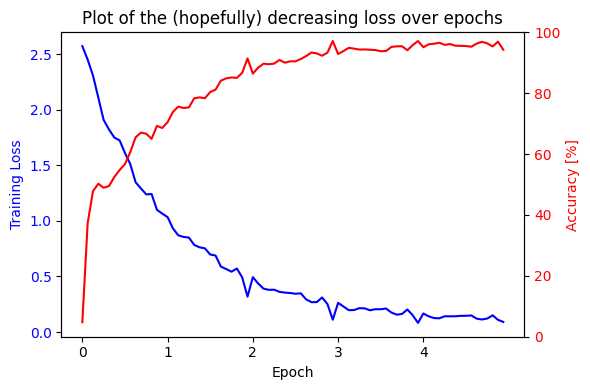

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot of the (hopefully) decreasing loss over epochs")
ax.plot(model.training_loss_, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
# ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(model.training_accuracy_, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():                                                           # Do not use the following forward passes to calculate a gradient
  n_correct = 0
  n_total = 0
  for inputs, targets in batch_iterator(X_test, y_test, batch_size=batch_size): # Loop once over the test data
    scores = model.forward(inputs)                                              # Runs the test data through the model
    predictions = scores.argmax(dim=2, keepdim=True).squeeze()                  # Finds the predictions
    mask = targets!=tag2idx['<PAD>']                                            # Create a mask for ignoring <PAD> in the targets
    n_correct += (predictions[mask] == targets[mask]).sum().item()              # Sums the number of correct predictions
    n_total += mask.sum().item()
print("Test accuracy %.1f%%" % (100*n_correct/n_total))


"""
- Model complexity and accuracy
I tested three following languages, Enlgish, Korean and Swedish for exploring how test accuracy changes in different dimensionality.
Comared to English and Swedish, Korean have a much higher morphological richness.
With 64 hidden dimension, test accuracy in English, Korean and Swedish are 95%, 61%, 75% respectively while with 128 hidden dimension 95%, 72% and 77%.
The test accuracy of Korean get almost 10% higher accuracy when using a higher dimension but The test accuracy of two others has very small or no improvement.
This result can show that model complexity (by changing dimensionalty in my test case) and accuracy are in relation to what lanuguages we use for PosTagging.

- Compare results with and without bidirectional option in LSMT, and GRU layers (English tagging)
Test accuracy of both LSTM and GRU without using bidirectional option are 95% and with using bidirectional option are 97%.
Those results can exmplain that using bidrectional option helps to improve the model performance.
"""


Test accuracy 95.6%


'\n- Model complexity and accuracy\nI tested three following languages, Enlgish, Korean and Swedish for exploring how test accuracy changes in different dimensionality.\nComared to English and Swedish, Korean have a much higher morphological richness.\nWith 64 hidden dimension, test accuracy in English, Korean and Swedish are 95%, 61%, 75% respectively while with 128 hidden dimension 95%, 72% and 77%.\nThe test accuracy of Korean get almost 10% higher accuracy when using a higher dimension but The test accuracy of two others has very small or no improvement.\nThis result can show that model complexity (by changing dimensionalty in my test case) and accuracy are in relation to what lanuguages we use for PosTagging.\n\n- Compare results with and without bidirectional option in LSMT, and GRU layers (English tagging)\nTest accuracy of both LSTM and GRU without using bidirectional option are 95% and with using bidirectional option are 97%.\nThose results can exmplain that using bidrectional